In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pprint

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [217]:
from sklearn import __version__ as skvers
skvers

'0.20.2'

## Define some useful feature engineering functions

Tweaking the train and test sets causes all sorts of warnings about 
mucking with copies of slices of a dataframe, so just set it on the 
whole dataset and we'll reslice at the end of feature engineering

In [218]:
def create_nan_category(column, fill):
    """create_nan_category(column)
           adds column_nan with one-hot where the nans were
           fills nans in column with fill
       returns df"""
    
    nan_col = column + "_nan"
    
    query = column + " != " + column
    nullidx = data.query(query).index
    data.loc[nullidx, column] = fill
    
    data[nan_col] = 0.0
    data.loc[nullidx, nan_col] = 1.0
    

def log_transform(column):
    """log_transform(column)
        creates the column column_log"""
    new_col = column + "_log"
    data[new_col] = np.log(data[column])
    
   
def log1p_transform(column):
    """log_transform(df, column)
       creates the column column_log"""
    new_col = column + "_log1p"
    data[new_col] = np.log1p(data[column])


def square_transform(column):
    """square_transform(df, column)
       creates the column column_squared"""
    new_col = column + "_squared"
    data[new_col] = np.square(data[column])

## Read in the data set

In [219]:
data = pd.read_pickle("../data/MERGED2016_17_select.pck")

In [220]:
data.shape

(1604, 31)

In [221]:
data.columns

Index(['GRAD_DEBT_MDN', 'MAIN', 'BACH_ONLY', 'PUBLIC', 'ADM_RATE', 'SAT_AVG',
       'UGDS', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
       'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN',
       'COSTT4_A', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITFTE', 'INEXPFTE',
       'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF', 'OPENADMIT', 'PRIVATE',
       'COMPADMIT', 'INSTNM', 'CITY', 'STABBR'],
      dtype='object')

### Train_test_split



In [222]:
y =  data['GRAD_DEBT_MDN']
X = data.drop(columns='GRAD_DEBT_MDN')

X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.20, random_state=42)

In [223]:
X_train.shape

(1283, 30)

In [224]:
X_test.shape

(321, 30)

In [225]:
y_train.shape

(1283,)

In [226]:
y_test.shape

(321,)

In [227]:
X_train_public = X_train.query("PUBLIC == 1")
X_train_private = X_train.query("PUBLIC == 0")

## Feature engineering of predictors

The predictors are sorted into categorical and numerical, since only the numerical ones will be scaled

In hindsight, this was not the way to do this. I needed to scatter plot the scaled featues 
versus the target as a better way to determine that feature engineering was needed. This
is way too scattershot.

In [228]:
predictors = [] # Add them to the list as we clean things up
categorical_predictors = [] # keep these separate as they are not scaled 

### Categorical columns

In [229]:
# I decided to keep only the public/private split as the most likely to be
# relevant and to avoid slicing data into too many pieces unnecessarily
X_train[['MAIN', 'BACH_ONLY', 'PUBLIC', 'PRIVATE', 'OPENADMIT']].sum()

MAIN         1235
BACH_ONLY     220
PUBLIC        458
PRIVATE       825
OPENADMIT      96
dtype: int64

In [230]:
categorical_predictors += [ 'PUBLIC' ]

### Numerical columns

#### Admission rate

/Users/jlc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


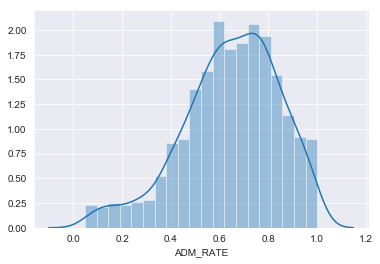

In [231]:
adm_rate = X_train.ADM_RATE.dropna()
sns.distplot(adm_rate)

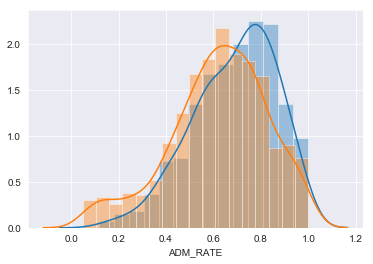

In [232]:
sns.distplot(X_train_public.ADM_RATE.dropna())
sns.distplot(X_train_private.ADM_RATE.dropna())

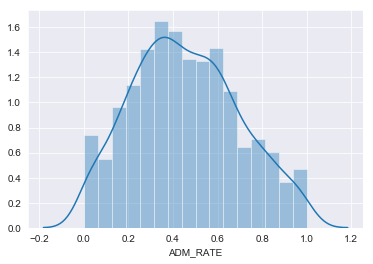

In [233]:
adm_rate = X_train.ADM_RATE.dropna()
sns.distplot(adm_rate * adm_rate)

In [234]:
X_train.ADM_RATE.count()

1194

In [235]:
X_test.ADM_RATE.count()

299

In [236]:
# Too much missing data to fudge -- 
# Add a new categorical column to mean "Admissions data not
# published"
create_nan_category('ADM_RATE', 0)
square_transform('ADM_RATE')

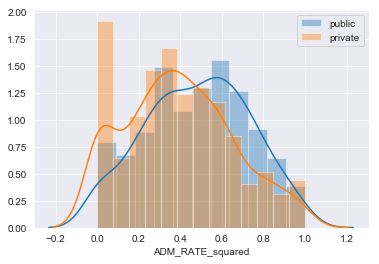

In [237]:
sns.distplot(data.loc[X_train_public.index, 'ADM_RATE_squared'], label="public")
sns.distplot(data.loc[X_train_private.index, 'ADM_RATE_squared'], label="private")
plt.legend()

In [238]:
categorical_predictors += [ 'ADM_RATE_nan']
predictors += [ 'ADM_RATE_squared', 'ADM_RATE' ] # check the untransformed too

#### SAT score

count     992.000000
mean     1065.633065
std       139.277190
min       712.000000
25%       972.750000
50%      1043.000000
75%      1122.000000
max      1555.000000
Name: SAT_AVG, dtype: float64


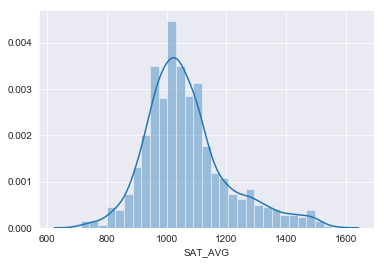

In [239]:
sns.distplot(X_train.SAT_AVG.dropna())
print(X_train.SAT_AVG.dropna().describe())

In [240]:
# plotting logs, squares didn't make a difference
# I guess this is normal enough for now

create_nan_category('SAT_AVG', 0)
categorical_predictors += [ 'SAT_AVG_nan' ]
predictors += [ 'SAT_AVG' ]

#### Number of undergrads

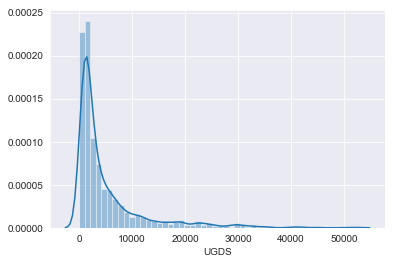

In [241]:
sns.distplot(X_train.UGDS)

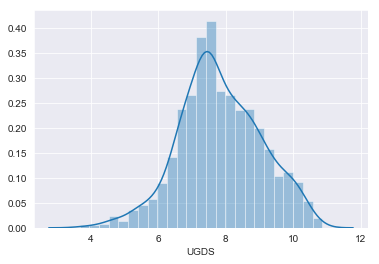

In [242]:
sns.distplot(np.log(X_train.UGDS))

In [243]:
log_transform('UGDS')
predictors += [ 'UGDS', 'UGDS_log']

#### Percent white undergrads 

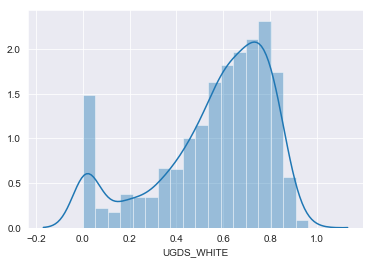

In [244]:
sns.distplot(X_train.UGDS_WHITE)

Text(0.5, 1.0, 'squared')

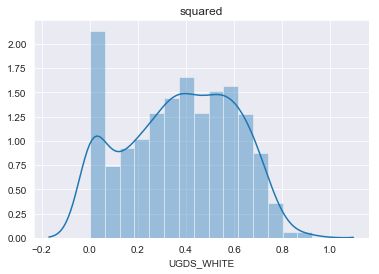

In [245]:
# Looks like a tail of minority serving institutions,
# and the rest is normal-ish. 
sns.distplot(np.square(X_train.UGDS_WHITE))
plt.title("squared")

In [246]:
square_transform('UGDS_WHITE')
predictors += [ 'UGDS_WHITE', 'UGDS_WHITE_squared' ]

#### Number of foreign students (Non Resident Aliens) - set aside for now

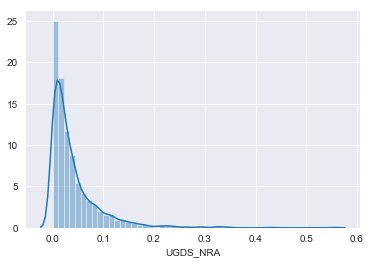

In [247]:
sns.distplot(X_train.UGDS_NRA)

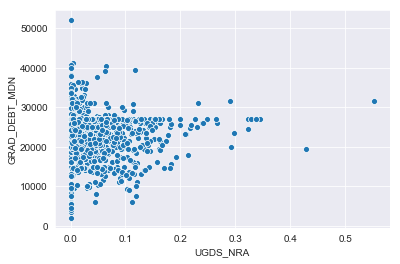

In [248]:
sns.scatterplot(X_train.UGDS_NRA, y_train)

In [249]:
# Doesn't want to un-spike (log1p, square, etc) set aside for now

#### Cost of attendance 

Lots of mostly collinear cost features

In [250]:
money_feats = ['COSTT4_A', 
               'TUITFTE',
               'TUITIONFEE_IN', 
               'TUITIONFEE_OUT',
              ]

In [251]:
X_train[money_feats].corr()

,COSTT4_A,TUITFTE,TUITIONFEE_IN,TUITIONFEE_OUT
COSTT4_A,1.000000,0.816415,0.981569,0.911448
TUITFTE,0.816415,1.000000,0.804368,0.781857
TUITIONFEE_IN,0.981569,0.804368,1.000000,0.899851
TUITIONFEE_OUT,0.911448,0.781857,0.899851,1.000000


In [252]:
data['COST'] = data.eval(
    'COSTT4_A + TUITFTE + TUITIONFEE_IN'
)
X_train_cost = data.loc[X_train.index, 'COST']

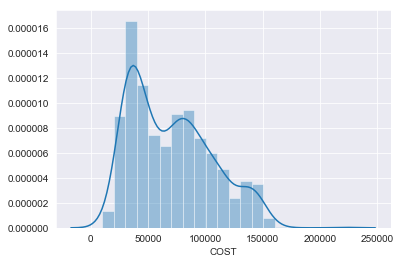

In [253]:
sns.distplot(X_train_cost)
# dual humps are likely public and private schools

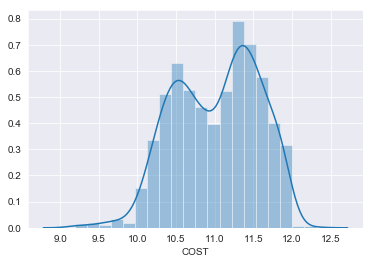

In [254]:
sns.distplot(np.log(X_train_cost))
# dual humps are likely public and private schools

In [255]:
log_transform('COST')

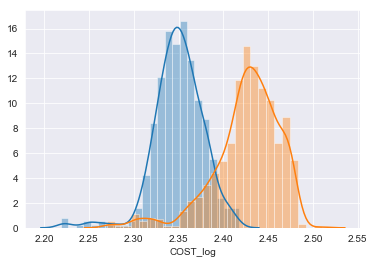

In [256]:
X_train_cost_log = data.loc[X_train.index, 'COST_log']
X_train_cost_log_public = X_train_cost_log.loc[X_train_public.index]
X_train_cost_log_private = X_train_cost_log.loc[X_train_private.index]

sns.distplot(np.log(X_train_cost_log_public))
sns.distplot(np.log(X_train_cost_log_private))

In [257]:
predictors += [ 'COST', 'COST_log' ] 

data['COST_P'] = data['COST'] * data['PUBLIC']
data['COST_log_P'] = data['COST_log'] * data['PUBLIC']

predictors += [ 'COST_P', 'COST_log_P' ]

data.COST_log.count()

1604

In [258]:
data.COST.count()

1604

In [259]:
predictors

['ADM_RATE_squared',
 'ADM_RATE',
 'SAT_AVG',
 'UGDS',
 'UGDS_log',
 'UGDS_WHITE',
 'UGDS_WHITE_squared',
 'COST',
 'COST_log',
 'COST_P',
 'COST_log_P']

#### Average faculty salary

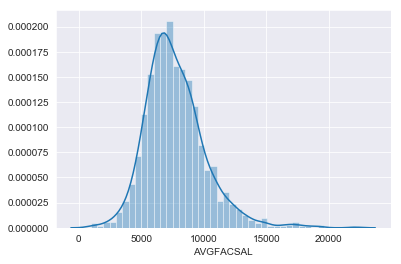

In [260]:
sns.distplot(X_train.AVGFACSAL.dropna())

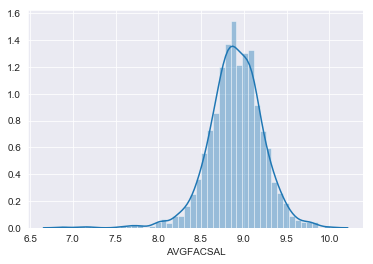

In [261]:
sns.distplot(np.log(X_train.AVGFACSAL.dropna()))

In [262]:
X_train.AVGFACSAL.count()

1281

In [263]:
X_test.AVGFACSAL.count()

321

In [264]:
# Missing 2 observations from train set and none from test set

idx = data.query('AVGFACSAL != AVGFACSAL').index
data.loc[idx, 'AVGFACSAL'] = data.AVGFACSAL.median()

predictors += [ 'AVGFACSAL' ]

log_transform('AVGFACSAL')

predictors += [ 'AVGFACSAL_log']

####  Percent part time faculty 

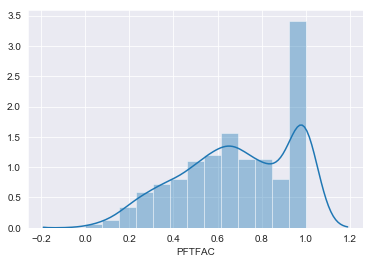

In [272]:
sns.distplot(X_train.PFTFAC.dropna())


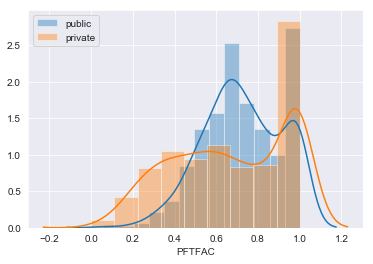

In [273]:
sns.distplot(X_train_public.PFTFAC.dropna(), label="public")
sns.distplot(X_train_private.PFTFAC.dropna(), label="private")
plt.legend()

In [274]:
X_train.PFTFAC.count()

1279

In [275]:
X_test.PFTFAC.count()

321

In [276]:
# Missing four values from training and none from test

In [277]:
idx = X_train_public.query('PFTFAC != PFTFAC').index
if len(idx):
    data.loc[idx, 'PFTFAC'] = X_train_public.PFTFAC.median()

idx = X_train_private.query('PFTFAC != PFTFAC').index
if len(idx):
    data.loc[idx, 'PFTFAC'] = X_train_private.PFTFAC.median()

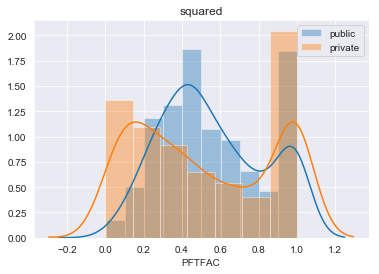

In [278]:
sns.distplot(np.square(X_train_public.PFTFAC), label="public")
sns.distplot(np.square(data.loc[X_train_private.index, 'PFTFAC']), label="private")
plt.title("squared")
plt.legend()

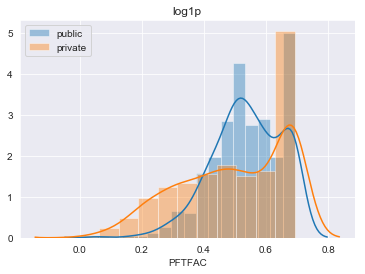

In [279]:
sns.distplot(np.log1p(X_train_public.PFTFAC), label="public")
sns.distplot(np.log1p(data.loc[X_train_private.index, 'PFTFAC']), label="private")
plt.title("log1p")
plt.legend()

In [280]:
predictors += [ 'PFTFAC' ]

#### Instructional expenditure per full time equivalent

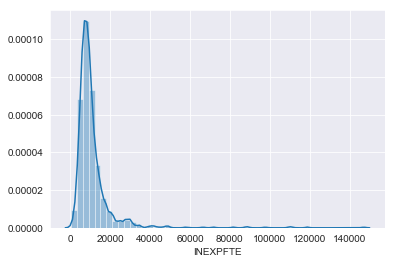

In [281]:
sns.distplot(X_train.INEXPFTE)

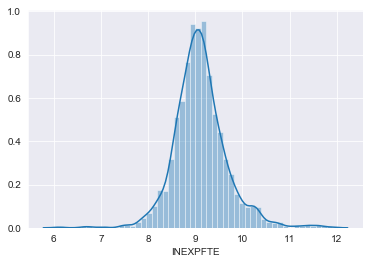

In [282]:
sns.distplot(np.log(X_train.INEXPFTE))

In [283]:
log_transform("INEXPFTE")
predictors += [ "INEXPFTE", "INEXPFTE_log"]

#### Percent of students receiving pell grants

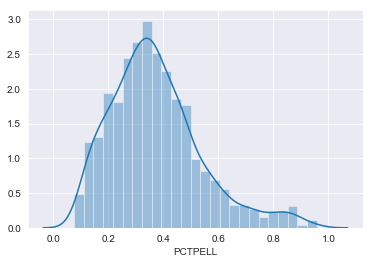

In [284]:
sns.distplot(X_train.PCTPELL)

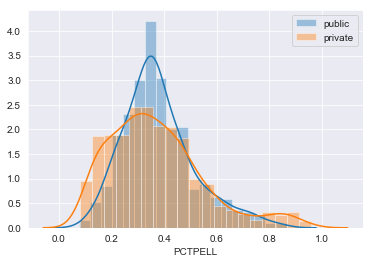

In [285]:
sns.distplot(X_train_public.PCTPELL, label="public")
sns.distplot(X_train_private.PCTPELL, label="private")
plt.legend()

In [286]:
predictors += [ 'PCTPELL' ]

#### Share of entering undergrads who are first-time, full-time, degree-seeking

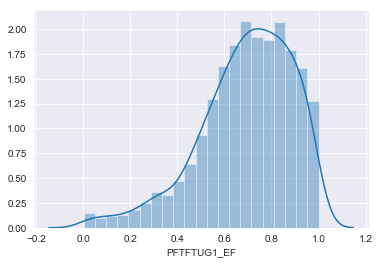

In [287]:
sns.distplot(X_train.PFTFTUG1_EF)

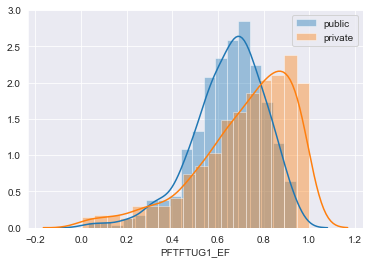

In [288]:
sns.distplot(X_train_public.PFTFTUG1_EF, label="public")
sns.distplot(X_train_private.PFTFTUG1_EF, label="private")
plt.legend()

In [289]:
predictors += ['PFTFTUG1_EF']

## Setting up modeling

In [290]:
def QQ_plot(obs):
    """QQ-plot of obs"""
    z = (obs-np.mean(obs))/np.std(obs)
    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()

In [291]:
def run_a_model(categorical, numerical):
    global X_train
    
    X_train_run  = data.loc[X_train.index,numerical]
    
    std = StandardScaler()
    std.fit(X_train_run.values)
    X_train_tr = std.transform(X_train_run.values)

    # add the categorical values
    X_tr_df = pd.DataFrame(data=X_train_tr, index=X_train_run.index, columns=numerical)
    for c in categorical:
        X_tr_df[c] = data.loc[X_train_run.index, c].astype(float)

    ridge_lr = RidgeCV(alphas=np.arange(0.1, 3.0, 0.05),  cv=10)
    lasso_lr = LassoCV(cv=10)
    
    for lr,name in zip([ridge_lr, lasso_lr], ["Ridge", "Lasso"]):
        lr.fit(X_tr_df.values, y_train)
        yhat = lr.predict(X_tr_df.values)
        r2 = r2_score(y_train, yhat)
        print(name, "alpha=", lr.alpha_, "intercept=", lr.intercept_, "r2=", r2)
        pprint.pprint(pd.DataFrame(index=X_tr_df.columns, data=lr.coef_))
        print("")

In [292]:
categorical_predictors

['PUBLIC', 'ADM_RATE_nan', 'SAT_AVG_nan']

In [293]:
predictors

['ADM_RATE_squared',
 'ADM_RATE',
 'SAT_AVG',
 'UGDS',
 'UGDS_log',
 'UGDS_WHITE',
 'UGDS_WHITE_squared',
 'COST',
 'COST_log',
 'COST_P',
 'COST_log_P',
 'AVGFACSAL',
 'AVGFACSAL_log',
 'PFTFAC',
 'INEXPFTE',
 'INEXPFTE_log',
 'PCTPELL',
 'PFTFTUG1_EF']

In [294]:
run_a_model(categorical_predictors, predictors)

Ridge alpha= 1.1500000000000004 intercept= 24837.941291208976 r2= 0.43578872849115236
                              0
ADM_RATE_squared   -1382.706806
ADM_RATE            1802.705146
SAT_AVG            -3465.191823
UGDS                -638.325869
UGDS_log             119.774822
UGDS_WHITE         -1848.991778
UGDS_WHITE_squared  1599.958832
COST               -5383.701063
COST_log            9575.511438
COST_P              -854.388547
COST_log_P          2793.661670
AVGFACSAL          -2118.788383
AVGFACSAL_log       1807.211493
PFTFAC               144.410905
INEXPFTE            -273.387189
INEXPFTE_log        -335.608496
PCTPELL              520.323893
PFTFTUG1_EF          590.813899
PUBLIC              -185.796540
ADM_RATE_nan        4647.204350
SAT_AVG_nan        -8841.666833

Lasso alpha= 1.9723062146513277 intercept= 25039.465489654445 r2= 0.43639426783689994
                               0
ADM_RATE_squared    -1378.510294
ADM_RATE             1778.679138
SAT_AVG             -398

In [295]:
categorical_predictors

['PUBLIC', 'ADM_RATE_nan', 'SAT_AVG_nan']

In [296]:
cats = categorical_predictors.copy()
cats.remove("PUBLIC")
# oddly public is the first thing lasso drove to zero!

In [297]:
cats

['ADM_RATE_nan', 'SAT_AVG_nan']

In [298]:
predictors_adm_r = list(predictors)
predictors_adm_r.remove("ADM_RATE_squared")

In [299]:
predictors_adm_r2 = list(predictors)
predictors_adm_r2.remove("ADM_RATE")

In [300]:
run_a_model(cats, predictors_adm_r)
run_a_model(cats, predictors_adm_r2)

Ridge alpha= 1.0500000000000003 intercept= 24977.981571890006 r2= 0.4336970956492092
                              0
ADM_RATE             103.536997
SAT_AVG            -3624.695849
UGDS                -629.981641
UGDS_log             170.238622
UGDS_WHITE         -1824.662974
UGDS_WHITE_squared  1580.813032
COST               -5506.017184
COST_log            9751.227141
COST_P              -835.730417
COST_log_P          2714.637905
AVGFACSAL          -2340.096526
AVGFACSAL_log       1953.590022
PFTFAC               141.503917
INEXPFTE            -387.211720
INEXPFTE_log        -295.607473
PCTPELL              514.108127
PFTFTUG1_EF          605.184029
ADM_RATE_nan        2823.062167
SAT_AVG_nan        -9193.618177

Lasso alpha= 1.9723062146513277 intercept= 25232.917974234657 r2= 0.4342231731186623
                               0
ADM_RATE               71.441105
SAT_AVG             -4116.585205
UGDS                 -610.723116
UGDS_log              175.481260
UGDS_WHITE          -183

In [301]:
cats.remove('SAT_AVG_nan')

In [302]:
predictors_no_adm = list(predictors)
predictors_no_adm.remove("ADM_RATE")
predictors_no_adm.remove("ADM_RATE_squared")

In [303]:
run_a_model(cats, predictors_no_adm)

Ridge alpha= 0.5500000000000002 intercept= 22971.799851611424 r2= 0.415826748456389
                               0
SAT_AVG               234.072277
UGDS                 -780.281830
UGDS_log              163.124203
UGDS_WHITE          -2093.737263
UGDS_WHITE_squared   1713.506259
COST                -6812.169330
COST_log            11362.628469
COST_P              -1745.854393
COST_log_P           4039.232109
AVGFACSAL           -2944.886206
AVGFACSAL_log        2308.041532
PFTFAC                108.276691
INEXPFTE             -446.930410
INEXPFTE_log         -527.123651
PCTPELL               746.693953
PFTFTUG1_EF           564.569607
ADM_RATE_nan         1683.604386

Lasso alpha= 1.9723062146513277 intercept= 22974.24202380686 r2= 0.4158654391819592
                               0
SAT_AVG               223.073820
UGDS                 -777.499525
UGDS_log              159.314337
UGDS_WHITE          -2076.689591
UGDS_WHITE_squared   1691.343727
COST                -6924.861742
COST_l

In [304]:
predictors_size = list(predictors_no_adm)
predictors_size.remove("UGDS_log")

predictors_size_log = list(predictors_no_adm)
predictors_size_log.remove("UGDS")

run_a_model(cats, predictors_size)
run_a_model(cats, predictors_size_log)

Ridge alpha= 0.5000000000000001 intercept= 22972.87041363436 r2= 0.41564249174838086
                               0
SAT_AVG               243.351619
UGDS                 -681.905353
UGDS_WHITE          -2117.149432
UGDS_WHITE_squared   1724.183660
COST                -6797.481494
COST_log            11363.887272
COST_P              -1801.142207
COST_log_P           4133.613085
AVGFACSAL           -2957.367154
AVGFACSAL_log        2369.448137
PFTFAC                111.143193
INEXPFTE             -442.627993
INEXPFTE_log         -561.840548
PCTPELL               733.687874
PFTFTUG1_EF           571.987119
ADM_RATE_nan         1668.171453

Lasso alpha= 1.9723062146513277 intercept= 22975.468135498915 r2= 0.41566203742341834
                               0
SAT_AVG               232.761799
UGDS                 -681.839107
UGDS_WHITE          -2091.864994
UGDS_WHITE_squared   1695.702630
COST                -6884.011963
COST_log            11448.229612
COST_P              -1831.166670
COS

In [305]:
cost_base = list(predictors_size)
cost_base.remove('COST')
cost_base.remove('COST_log')
cost_base.remove('COST_P')
cost_base.remove('COST_log_P')

In [306]:
cost_plain = list(cost_base)
cost_plain.append('COST')
cost_plain.append('COST_P')
cost_log = list(cost_base)
cost_log.append('COST_log')
cost_log.append('COST_log_P')

In [307]:
print(data.loc[X_train.index,'COST'].count())
print(data.loc[X_train.index,'COST_P'].count())

1283
1283


In [308]:
run_a_model(cats, cost_plain)

Ridge alpha= 2.3000000000000007 intercept= 22989.0666111754 r2= 0.275700851649207
                              0
SAT_AVG              639.783776
UGDS                -659.673366
UGDS_WHITE           -89.350481
UGDS_WHITE_squared   373.847833
AVGFACSAL          -4706.592382
AVGFACSAL_log       3606.890474
PFTFAC               -42.429206
INEXPFTE           -1255.340611
INEXPFTE_log          51.477069
PCTPELL             1119.154879
PFTFTUG1_EF          217.557346
COST                3737.144303
COST_P              1585.559188
ADM_RATE_nan        1434.691437

Lasso alpha= 10.4372682771451 intercept= 23005.421252936274 r2= 0.2753384331976956
                              0
SAT_AVG              599.619102
UGDS                -647.199943
UGDS_WHITE             0.000000
UGDS_WHITE_squared   270.785069
AVGFACSAL          -4615.730566
AVGFACSAL_log       3522.482161
PFTFAC               -25.755479
INEXPFTE           -1218.839526
INEXPFTE_log           0.000000
PCTPELL             1080.103274
PF

In [309]:
run_a_model(cats, cost_log)

Ridge alpha= 1.7500000000000007 intercept= 22978.268117863983 r2= 0.36355632143222605
                              0
SAT_AVG              510.424760
UGDS                -508.020706
UGDS_WHITE         -1511.322147
UGDS_WHITE_squared  1545.132865
AVGFACSAL          -4020.811866
AVGFACSAL_log       2890.536294
PFTFAC                67.874586
INEXPFTE            -825.199455
INEXPFTE_log        -580.495523
PCTPELL             1225.157719
PFTFTUG1_EF          163.251891
COST_log            5436.639943
COST_log_P          2617.968585
ADM_RATE_nan        1590.359604

Lasso alpha= 2.997730074625501 intercept= 22978.840809487683 r2= 0.3635905842982716
                              0
SAT_AVG              506.144930
UGDS                -500.020755
UGDS_WHITE         -1502.635181
UGDS_WHITE_squared  1533.073768
AVGFACSAL          -4088.204236
AVGFACSAL_log       2939.203725
PFTFAC                65.650750
INEXPFTE            -805.236795
INEXPFTE_log        -589.458132
PCTPELL             1226.8699

In [310]:
data['COST2'] = data.eval('COST * COST')
data['COST2_P'] = data.eval('COST2 * PUBLIC')

In [311]:
cost_plain.append('COST2')
cost_plain.append('COST2_P')
run_a_model(cats, cost_plain)

/Users/jlc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge alpha= 1.1000000000000005 intercept= 22968.307727856594 r2= 0.36024101147876864
                               0
SAT_AVG               387.969872
UGDS                 -699.088443
UGDS_WHITE          -1302.592550
UGDS_WHITE_squared   1173.578435
AVGFACSAL           -3759.407898
AVGFACSAL_log        2926.269577
PFTFAC                 84.377211
INEXPFTE             -203.649732
INEXPFTE_log         -545.686945
PCTPELL               875.434270
PFTFTUG1_EF           318.377996
COST                12932.449079
COST_P               4531.856144
COST2               -9078.453482
COST2_P             -2306.497597
ADM_RATE_nan         1733.945901

Lasso alpha= 3.6647250102497684 intercept= 22971.243652087367 r2= 0.3607664011919769
                               0
SAT_AVG               364.632406
UGDS                 -691.564033
UGDS_WHITE          -1308.931455
UGDS_WHITE_squared   1164.725373
AVGFACSAL           -3663.353530
AVGFACSAL_log        2820.378382
PFTFAC                 89.915175
INE

In [312]:
new_preds = list(predictors_size)
new_preds.remove('COST')
new_preds.remove('COST_P')

In [313]:
facsal_plain = list(new_preds)
facsal_plain.remove('AVGFACSAL_log')

In [314]:
facsal_log = list(new_preds)
facsal_log.remove('AVGFACSAL')

In [315]:
run_a_model(cats, facsal_plain)
run_a_model(cats, facsal_log)

Ridge alpha= 2.950000000000001 intercept= 23019.42097677636 r2= 0.34604277656676763
                              0
SAT_AVG              462.283519
UGDS                -595.561341
UGDS_WHITE         -1438.159232
UGDS_WHITE_squared  1526.690351
COST_log            5678.800608
COST_log_P          2943.507197
AVGFACSAL          -1252.920830
PFTFAC                96.210297
INEXPFTE           -1382.323823
INEXPFTE_log        -275.992902
PCTPELL             1175.903394
PFTFTUG1_EF           85.896435
ADM_RATE_nan         997.111088

Lasso alpha= 3.4466611236148466 intercept= 23020.80900503419 r2= 0.3461271202073123
                              0
SAT_AVG              455.390310
UGDS                -592.261001
UGDS_WHITE         -1485.068383
UGDS_WHITE_squared  1569.723409
COST_log            5757.586482
COST_log_P          3003.770793
AVGFACSAL          -1271.750268
PFTFAC                95.076951
INEXPFTE           -1370.179808
INEXPFTE_log        -293.829206
PCTPELL             1185.448103

In [316]:
inexp = list(facsal_plain)
inexp.remove('INEXPFTE_log')

In [317]:
inexp_log = list(facsal_plain)
inexp_log.remove('INEXPFTE')

In [318]:
run_a_model(cats, inexp)
run_a_model(cats, inexp_log)

Ridge alpha= 2.950000000000001 intercept= 23014.46748851778 r2= 0.34541031783240406
                              0
SAT_AVG              472.287139
UGDS                -589.800951
UGDS_WHITE         -1393.865705
UGDS_WHITE_squared  1492.823162
COST_log            5550.045558
COST_log_P          2844.581175
AVGFACSAL          -1285.454336
PFTFAC                92.009546
INEXPFTE           -1534.695822
PCTPELL             1195.267848
PFTFTUG1_EF           77.166803
ADM_RATE_nan        1068.519239

Lasso alpha= 4.2492049282102915 intercept= 23016.726458687244 r2= 0.34545095100662715
                              0
SAT_AVG              462.937003
UGDS                -585.251549
UGDS_WHITE         -1399.582063
UGDS_WHITE_squared  1498.082546
COST_log            5601.478789
COST_log_P          2883.645717
AVGFACSAL          -1300.882005
PFTFAC                90.100047
INEXPFTE           -1532.294887
PCTPELL             1205.944167
PFTFTUG1_EF           67.284317
ADM_RATE_nan        1035.9545

/Users/jlc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [319]:
white_plain = inexp.copy()
white_plain.remove('UGDS_WHITE_squared')

white_squared = inexp.copy()
white_squared.remove('UGDS_WHITE')

run_a_model(cats, white_plain)
run_a_model(cats, white_squared)

Ridge alpha= 2.950000000000001 intercept= 23010.49461515294 r2= 0.34045594767314935
                        0
SAT_AVG        464.802857
UGDS          -613.580123
UGDS_WHITE     111.554795
COST_log      5311.037266
COST_log_P    2730.293090
AVGFACSAL    -1281.690461
PFTFAC         108.958579
INEXPFTE     -1552.633845
PCTPELL       1272.436135
PFTFTUG1_EF    228.514238
ADM_RATE_nan  1125.791110

Lasso alpha= 2.4315512859142134 intercept= 23009.211605367604 r2= 0.3405170883738293
                        0
SAT_AVG        463.713762
UGDS          -612.436986
UGDS_WHITE     104.363027
COST_log      5382.824808
COST_log_P    2788.490235
AVGFACSAL    -1306.071761
PFTFAC         109.059083
INEXPFTE     -1553.503430
PCTPELL       1284.632913
PFTFTUG1_EF    221.567192
ADM_RATE_nan  1144.286633

Ridge alpha= 2.950000000000001 intercept= 23010.41148252977 r2= 0.34151070453743104
                              0
SAT_AVG              452.303223
UGDS                -601.851542
UGDS_WHITE_squared   256.

In [320]:
one_wealth = inexp.copy()
one_wealth.remove('UGDS_WHITE')
one_wealth.remove('SAT_AVG')

run_a_model([], one_wealth)

Ridge alpha= 2.950000000000001 intercept= 23088.58924395947 r2= 0.3363181507010372
                              0
UGDS                -579.243413
UGDS_WHITE_squared   296.503562
COST_log            5303.925524
COST_log_P          2727.602806
AVGFACSAL          -1144.095676
PFTFAC               132.704250
INEXPFTE           -1509.839430
PCTPELL             1352.703713
PFTFTUG1_EF          192.438020

Lasso alpha= 2.1148393057378754 intercept= 23088.58924395947 r2= 0.3363762134795709
                              0
UGDS                -578.174756
UGDS_WHITE_squared   295.230583
COST_log            5376.606687
COST_log_P          2785.777900
AVGFACSAL          -1166.323041
PFTFAC               132.579136
INEXPFTE           -1510.447371
PCTPELL             1372.530326
PFTFTUG1_EF          185.171778



In [321]:
predictors = white_squared
categories = cats

In [322]:
X_train  = data.loc[X_train.index,predictors]
X_test   = data.loc[X_test.index,predictors]

In [323]:
std = StandardScaler()
std.fit(X_train.values)
X_train_tr = std.transform(X_train.values)
X_test_tr = std.transform(X_test.values)

# add the categorical values
X_tr_df = pd.DataFrame(data=X_train_tr, index=X_train.index, columns=predictors)
for c in categories:
    X_tr_df[c] = data.loc[X_train.index, c].astype(float)

ridge_lr = RidgeCV(cv=10, alphas=np.arange(3.0, 6.0, 0.1))
lasso_lr = LassoCV(cv=10)

In [324]:
for lr,name in zip([ridge_lr, lasso_lr], ["Ridge", "Lasso"]):
    lr.fit(X_tr_df.values, y_train)
    yhat = lr.predict(X_tr_df.values)
    r2 = r2_score(y_train, yhat)
    print(name, "alpha=", lr.alpha_, "intercept=", lr.intercept_, "r2=", r2)
    pprint.pprint(pd.DataFrame(index=X_tr_df.columns, data=lr.coef_))
    print("")

Ridge alpha= 4.800000000000002 intercept= 23013.818300253337 r2= 0.34139235679898783
                              0
SAT_AVG              447.863909
UGDS                -600.474862
UGDS_WHITE_squared   255.114715
COST_log            5274.398080
COST_log_P          2672.852071
AVGFACSAL          -1197.541757
PFTFAC               100.029162
INEXPFTE           -1535.982705
PCTPELL             1356.890885
PFTFTUG1_EF          203.237189
ADM_RATE_nan        1077.877762

Lasso alpha= 2.2676728673617923 intercept= 23008.78699763949 r2= 0.3415742008197815
                              0
SAT_AVG              451.302372
UGDS                -600.732285
UGDS_WHITE_squared   255.349916
COST_log            5411.075544
COST_log_P          2783.763165
AVGFACSAL          -1236.880433
PFTFAC               101.551353
INEXPFTE           -1539.040372
PCTPELL             1393.466039
PFTFTUG1_EF          192.954551
ADM_RATE_nan        1150.407663



In [325]:
lr = ridge_lr

In [326]:
yhat = lr.predict(X_tr_df.values)

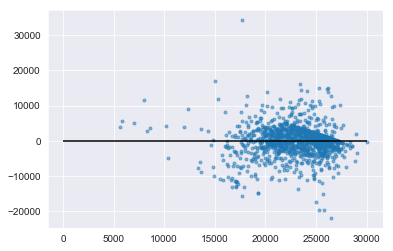

In [327]:
plt.scatter(yhat, y_train - yhat, marker=".", alpha=0.5) 
plt.hlines(0, 0, 30000)

/Users/jlc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


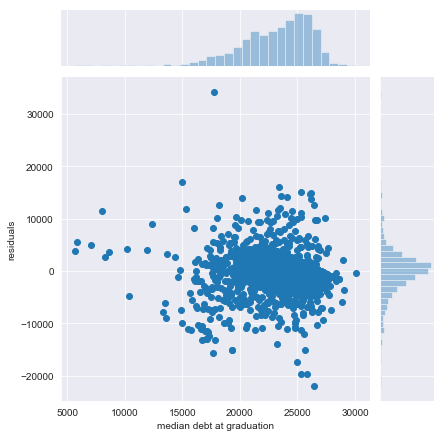

In [328]:
sns.jointplot(x=yhat, y=(y_train - yhat)).set_axis_labels("median debt at graduation", "residuals")

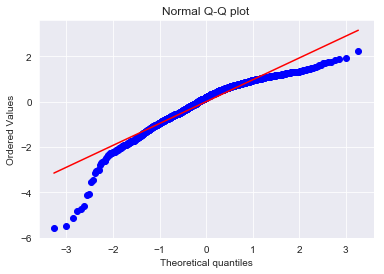

In [329]:
QQ_plot(yhat)

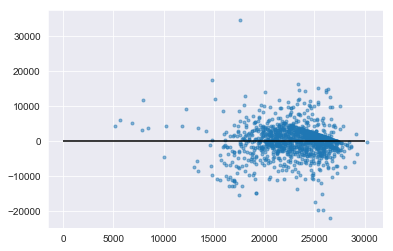

In [330]:
lr = lasso_lr
yhat = lr.predict(X_tr_df.values)
plt.scatter(yhat, y_train - yhat, 
            marker = ".", alpha=0.5)
plt.hlines(0,0,30000)

/Users/jlc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


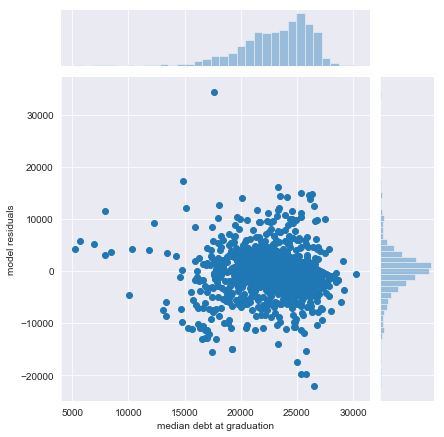

In [331]:
sns.jointplot(x=yhat, y=(y_train-yhat)).set_axis_labels(
    "median debt at graduation", "model residuals")

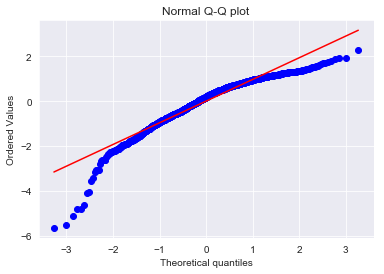

In [332]:
QQ_plot(yhat)

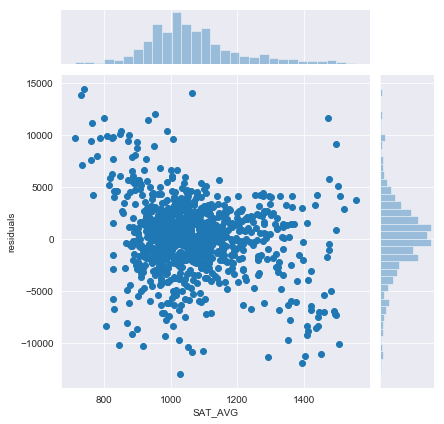

In [333]:
# SAT AVG plot clean
sns.set_style('darkgrid')

sat_idx = X_train.query('SAT_AVG > 100').index

sat_x = X_train.loc[sat_idx, 'SAT_AVG']
sat_y = (y_train - yhat).loc[sat_idx,] 

sns.jointplot(x=sat_x, y=sat_y).set_axis_labels('SAT_AVG', 'residuals')

SAT_AVG


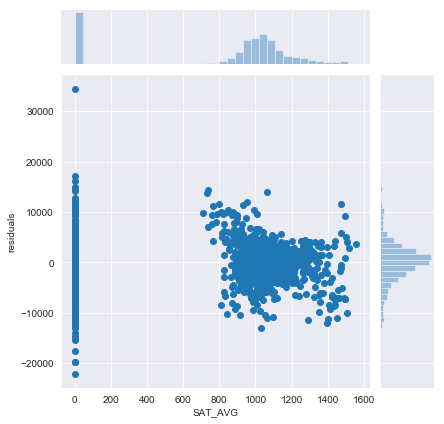

UGDS


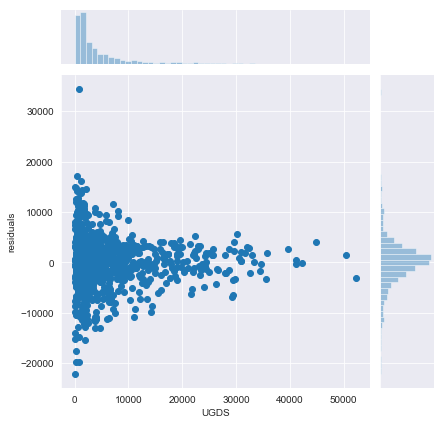

UGDS_WHITE_squared


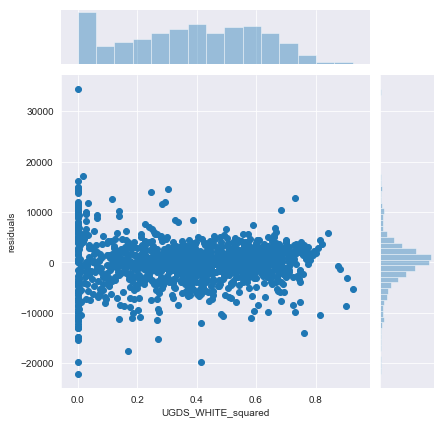

COST_log


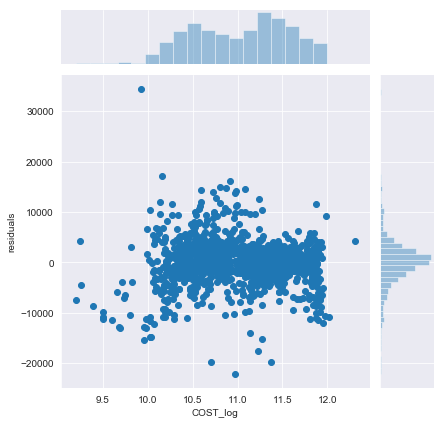

COST_log_P


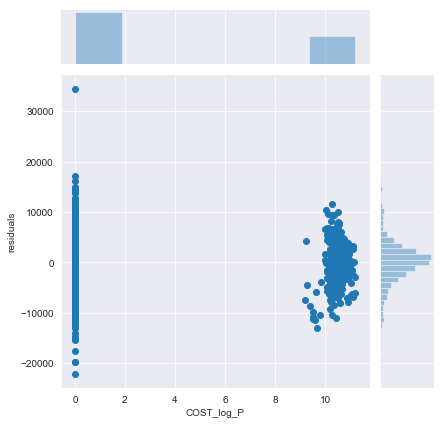

AVGFACSAL


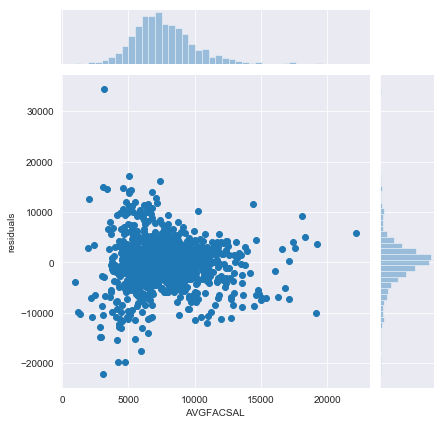

PFTFAC


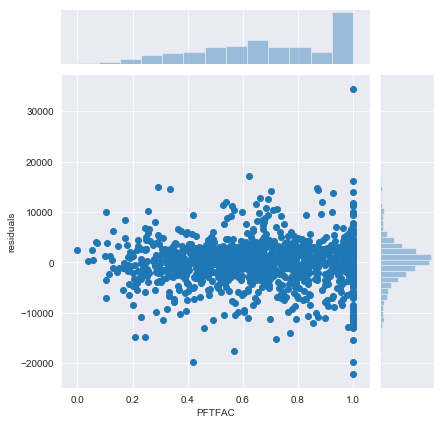

INEXPFTE


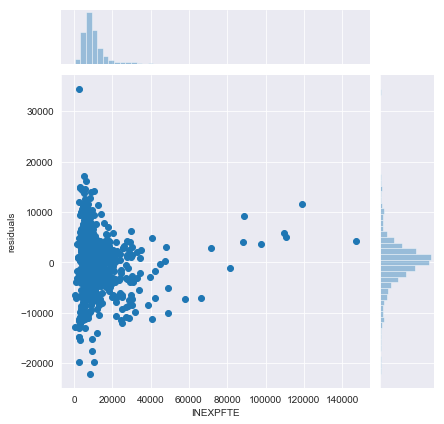

PCTPELL


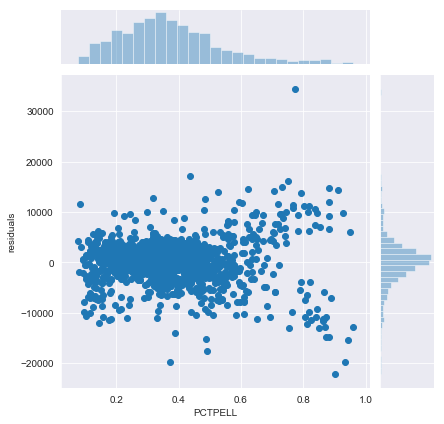

PFTFTUG1_EF


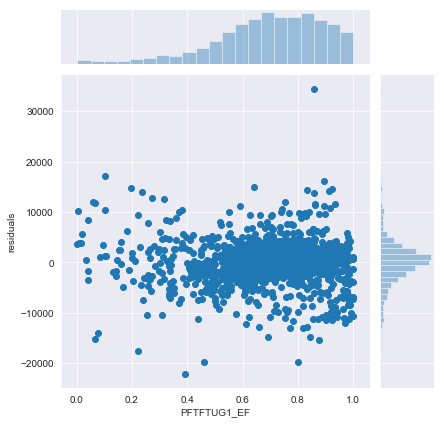

In [334]:
for c in predictors:
    print(c)
    if True:
        sns.jointplot(x=X_train[c], y=(y_train - yhat)).set_axis_labels(c, "residuals")
    else:
        plt.scatter(X_train[c], y_train - yhat, marker=".", alpha=0.5) 
        plt.hlines(0,0,X_train[c].max())
    plt.show()


In [335]:
resid = y_train - yhat
resid_public = resid[X_train_public.index]
resid_private = resid[X_train_private.index]


X_train_pub2plot = data.loc[X_train.index,:].query('PUBLIC == 1')
X_train_priv2plot = data.loc[X_train.index,:].query('PUBLIC == 0')


SAT_AVG


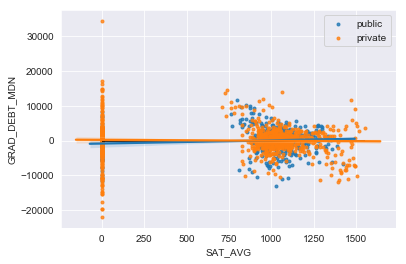

UGDS


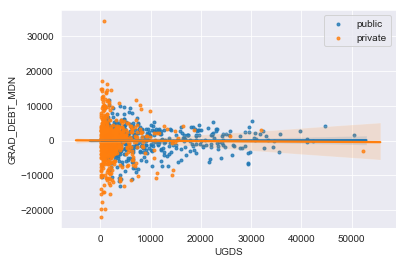

UGDS_WHITE_squared


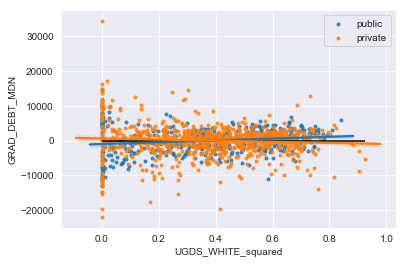

COST_log


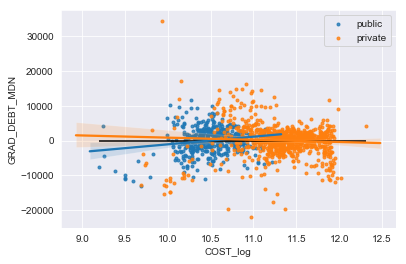

COST_log_P


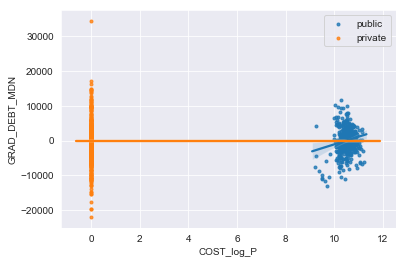

AVGFACSAL


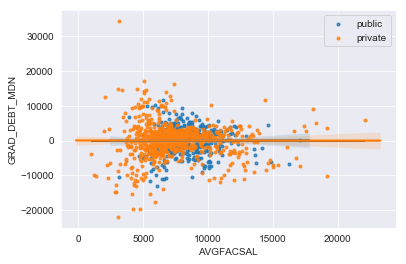

PFTFAC


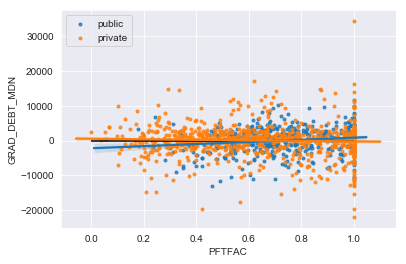

INEXPFTE


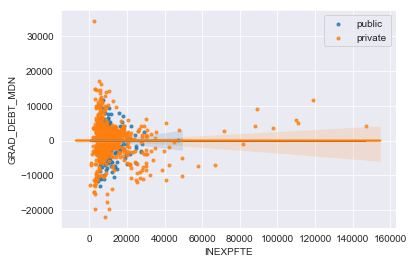

PCTPELL


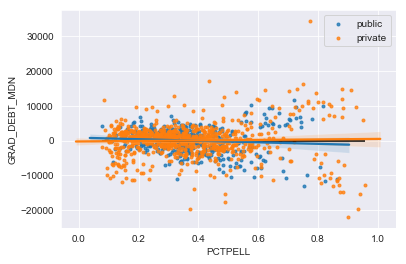

PFTFTUG1_EF


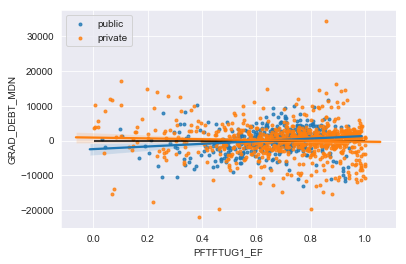

In [336]:
for c in predictors:
    print(c)
    if True:
        sns.regplot(X_train_pub2plot.loc[:, c], resid_public, marker='.', label='public')
        sns.regplot(X_train_priv2plot.loc[:, c], resid_private, marker='.', label='private')
    else:
        plt.scatter(X_train_pub2plot.loc[:, c], resid_public, marker='.', alpha=0.5, label='public')
        plt.scatter(X_train_priv2plot.loc[:, c], resid_private, marker='.', alpha=0.5, label='private')
        
    plt.hlines(0,X_train[c].min(),X_train[c].max())
    plt.legend()
    plt.show()

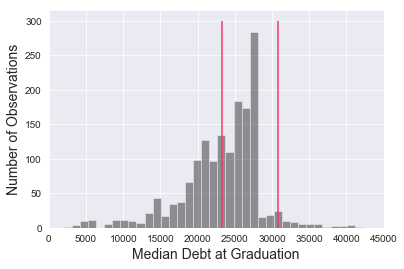

In [337]:
sns.distplot(data.GRAD_DEBT_MDN, kde=False, color='black')
plt.vlines(27000 - 3750, 0, 300, linewidth=1.5, color=(238/255, 57/255, 103/255))
plt.vlines(27000 + 3750, 0, 300, linewidth=1.5, color=(238/255, 57/255, 103/255))
plt.xlim((0,45000))
plt.gca().set_ylabel("Number of Observations", fontsize=14)
plt.gca().set_xlabel("Median Debt at Graduation", fontsize=14)
plt.savefig("../plots/targetdbn.svg")
# plt.suptitle("Most schools report median borrowing at or near \nthe program limit for 3.5 to 4.5 years of study.", fontsize=14)